#NLP, LangChain, VectorDB Example

###Installations and Imports

In [ ]:
#!pip install spacy
!pip install pandas spacy matplotlib seaborn
!python -m spacy download en_core_web_sm

!pip install pinecone-client transformers
!pip install "pinecone-client[grpc]"

!pip install protobuf==3.20.3
!pip install grpcio==1.56.0
!pip install grpcio-tools==1.56.0
!pip install googleapis-common-protos==1.58.0

!pip install protoc_gen_openapiv2

!pip install -U sentence-transformers -q

!pip install transformers torch

!pip install --upgrade langchain

!pip install langchain_openai

!pip install langchain_pinecone

In [ ]:
import pandas as pd
import re
import os
import numpy as np

import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

import pinecone
from transformers import AutoTokenizer, AutoModel
import torch

# Initialize Pinecone
from pinecone import Pinecone # import the Pinecone class

from transformers import pipeline, AutoModelForCausalLM

###Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create path files for easy access to data files
GD_path = r'/content/drive/MyDrive'
file_path = os.path.join(GD_path, 'Bloomberg_7_15-8_13.csv')

In [ ]:
# Load the dataset
df1 = pd.read_csv(file_path)

In [ ]:
df = df1

In [ ]:
df

,link,date,content,title
0,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Bangladesh’s interim government appointed a fo...,Bangladesh Names Former IMF Official as Centra...
1,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Thousands of demonstrators assembled in Slovak...,Slovaks Take to Streets to Protest Against Pre...
2,https://www.bloomberg.com/news/newsletters/202...,2024-08-13,You’re reading the Businessweek Daily newslett...,"What Trump Gets From Musk, and Musk From Trump"
3,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,South Africa’s financial regulator said it’s o...,South Africa’s Regulator Cautions Against Pres...
4,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Financial markets are flashing a higher probab...,"Goldman, JPMorgan Say Markets Pricing in Highe..."
...,...,...,...,...
2551,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Sales of Swiss-made luxury watches are in shar...,Swiss Luxury Watch Market Succumbs to a Brutal...
2552,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Amazon.com Inc.â€™s Prime Day sales rose almos...,Amazon Prime Day Sales Up 12% in First Seven H...
2553,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Family offices with at least $1 billion in ass...,Family Offices Snub Hedge Funds for Quant Bets...
2554,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,The US presidential election has seen a wave o...,Billionaires Take Sides as Turbulent President...


###Clean the text

In [ ]:
# Function to clean text for special characters
def clean_text(text):
    # Remove special characters and digits, keep only words and spaces
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove any extra whitespace or newlines
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Clean the 'content' column
df['cleaned_content'] = df['content'].apply(clean_text)

In [ ]:
df

,link,date,content,title,cleaned_content
0,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Bangladesh’s interim government appointed a fo...,Bangladesh Names Former IMF Official as Centra...,Bangladeshs interim government appointed a for...
1,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Thousands of demonstrators assembled in Slovak...,Slovaks Take to Streets to Protest Against Pre...,Thousands of demonstrators assembled in Slovak...
2,https://www.bloomberg.com/news/newsletters/202...,2024-08-13,You’re reading the Businessweek Daily newslett...,"What Trump Gets From Musk, and Musk From Trump",Youre reading the Businessweek Daily newslette...
3,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,South Africa’s financial regulator said it’s o...,South Africa’s Regulator Cautions Against Pres...,South Africas financial regulator said its opp...
4,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Financial markets are flashing a higher probab...,"Goldman, JPMorgan Say Markets Pricing in Highe...",Financial markets are flashing a higher probab...
...,...,...,...,...,...
2551,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Sales of Swiss-made luxury watches are in shar...,Swiss Luxury Watch Market Succumbs to a Brutal...,Sales of Swissmade luxury watches are in sharp...
2552,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Amazon.com Inc.â€™s Prime Day sales rose almos...,Amazon Prime Day Sales Up 12% in First Seven H...,Amazoncom Incs Prime Day sales rose almost in ...
2553,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Family offices with at least $1 billion in ass...,Family Offices Snub Hedge Funds for Quant Bets...,Family offices with at least billion in assets...
2554,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,The US presidential election has seen a wave o...,Billionaires Take Sides as Turbulent President...,The US presidential election has seen a wave o...


###Spacy model and extract entities

In [ ]:
# Load a pre-trained spaCy model
nlp_sm = spacy.load('en_core_web_sm')

In [ ]:
# Function to extract organizations (companies) from text
def extract_entities(text):
    doc = nlp_sm(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'ORG']

In [ ]:
# Apply entity extraction
df['org_entities'] = df['cleaned_content'].apply(extract_entities)

In [ ]:
df

,link,date,content,title,cleaned_content,org_entities
0,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Bangladesh’s interim government appointed a fo...,Bangladesh Names Former IMF Official as Centra...,Bangladeshs interim government appointed a for...,"[the International Monetary Fund, Bangladesh B..."
1,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Thousands of demonstrators assembled in Slovak...,Slovaks Take to Streets to Protest Against Pre...,Thousands of demonstrators assembled in Slovak...,"[Slovakias, the European Union, Slovak Nationa..."
2,https://www.bloomberg.com/news/newsletters/202...,2024-08-13,You’re reading the Businessweek Daily newslett...,"What Trump Gets From Musk, and Musk From Trump",Youre reading the Businessweek Daily newslette...,"[Businessweek Daily, the Privacy Policy and Te..."
3,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,South Africa’s financial regulator said it’s o...,South Africa’s Regulator Cautions Against Pres...,South Africas financial regulator said its opp...,"[The African National Congress, ANC, the Finan..."
4,https://www.bloomberg.com/news/articles/2024-0...,2024-08-13,Financial markets are flashing a higher probab...,"Goldman, JPMorgan Say Markets Pricing in Highe...",Financial markets are flashing a higher probab...,"[Goldman Sachs Group Inc, JPMorgan Chase Co, G..."
...,...,...,...,...,...,...
2551,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Sales of Swiss-made luxury watches are in shar...,Swiss Luxury Watch Market Succumbs to a Brutal...,Sales of Swissmade luxury watches are in sharp...,"[Richemont, Swatch Group AG, Burberry Group Pl..."
2552,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Amazon.com Inc.â€™s Prime Day sales rose almos...,Amazon Prime Day Sales Up 12% in First Seven H...,Amazoncom Incs Prime Day sales rose almost in ...,"[Amazoncom, Momentum Commerce, Amazon, Amazon,..."
2553,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,Family offices with at least $1 billion in ass...,Family Offices Snub Hedge Funds for Quant Bets...,Family offices with at least billion in assets...,"[Citigroup Inc, Family Office Group, Hannes Ho..."
2554,https://www.bloomberg.com/news/articles/2024-0...,2024-07-16,The US presidential election has seen a wave o...,Billionaires Take Sides as Turbulent President...,The US presidential election has seen a wave o...,"[Elon Musks, Future Forward, Google, the Democ..."


In [ ]:
df['org_entities']

,org_entities
0,"[the International Monetary Fund, Bangladesh B..."
1,"[Slovakias, the European Union, Slovak Nationa..."
2,"[Businessweek Daily, the Privacy Policy and Te..."
3,"[The African National Congress, ANC, the Finan..."
4,"[Goldman Sachs Group Inc, JPMorgan Chase Co, G..."
...,...
2551,"[Richemont, Swatch Group AG, Burberry Group Pl..."
2552,"[Amazoncom, Momentum Commerce, Amazon, Amazon,..."
2553,"[Citigroup Inc, Family Office Group, Hannes Ho..."
2554,"[Elon Musks, Future Forward, Google, the Democ..."


In [ ]:
def clean_org_entities(org_list):
    cleaned_orgs = []
    for org in org_list:
        # Remove common false positives or unwanted terms
        if org.lower() in ["inc.", "llc", "company", "corp"]:
            continue

        # Remove special characters and trailing punctuation
        org = org.replace("Inc.", "").replace("LLC", "").replace("Corp", "").strip()

        # Optionally check if the organization is in a whitelist of relevant organizations
        #if org in relevant_orgs:
            #cleaned_orgs.append(org)
        #else:
            # Additional rules can be applied here
            # For instance, filter by length or whether it's purely alphabetic
            #if len(org) > 2 and org.isalpha():
                #cleaned_orgs.append(org)
        if len(org) > 2 and org.isalpha():
          cleaned_orgs.append(org)

    return cleaned_orgs

In [ ]:
df['cleaned_org_entities'] = df['org_entities'].apply(clean_org_entities)

### Unique entities

In [ ]:
# Assuming df is your DataFrame with the 'org_entities' column
# Explode the 'org_entities' column
all_entities = df['org_entities'].explode()

# Drop NaN values if any
all_entities = all_entities.dropna()

# Get unique entities
unique_entities = all_entities.unique()

print(unique_entities)

['the International Monetary Fund' 'Bangladesh Bank' 'Bloomberg News' ...
 'staterun state news agency' 'Agerpres A' 'Marius Somesan']


In [ ]:
print(len(unique_entities))

15249


In [ ]:
# Assuming df is your DataFrame with the 'org_entities' column
# Explode the 'org_entities' column
all_cleaned_entities = df['cleaned_org_entities'].explode()

# Drop NaN values if any
all_cleaned_entities = all_cleaned_entities.dropna()

# Get unique entities
unique_cleaned_entities_1 = all_cleaned_entities.unique()

print(unique_cleaned_entities_1)

['Bangladesh' 'IMF' 'Slovakias' ... 'Unexpected' 'Winklevosses' 'Adelson']


In [ ]:
list_unique_cleaned_entities = ['GOP', 'Starbucks',
 'WhatsApp', 'Apollo', 'Blackstone', 'TikTok', 'Bloomberg', 'ANC', 'Treasury',
 'Goldman', 'JPMorgan', 'Nasdaq', 'Goldmans', 'MuellerGlissmann',
 'Wilson', 'Google', 'Pixel', 'Apple', 'Ultra', 'Autofocus', 'Reimagine', 'Klike', 'JetBlues',
 'Telegram', 'WRC', 'YPF', 'Kroger', 'FTC', 'Microsoft', 'Spirit',
 'USDA', 'Chipotle', 'Bernstein', 'Coinbase', 'SEC', 'Pentagon', 'Fulbright', 'Walz',
 'McDonalds', 'Harvard', 'VIX', 'Credit', 'Nuveen', 'Luzzetti', 'TVGO','CDU', 'IPO', 'Reuters', 'Temu',
 'ANA', 'Amazon', 'Nvidia', 'MTUM', 'DBSA','Illuminas', 'CME',
 'UAW', 'eThekwini', 'BBB', 'CPPIB', 'CDC', 'WHO', 'UKEU',
 'Donohoe', 'YouGov', 'NATO', 'SaffirSimpson', 'Ofgem', 'Paramount', 'CBS', 'Viacom',
 'NatWest', 'SRT', 'RBI', 'Deutsches', 'EQT', 'CNBC', 'IHS', 'MTN','Adani',
 'Elites', 'Solaris', 'Global', 'OPEC', 'DAC', 'CapturePoint', 'GSAM',
 'Vantive', 'Baxters', 'Aspell', 'Metlen', 'Mytilineos', 'Coke', 'BOE', 'CNN',
 'STRS', 'Citigroup', 'YouTube', 'OPIN',
 'BNEF', 'SSAB', 'Ynet', 'FTSE','NFIB',
 'HCG', 'CVC', 'Kimshealth', 'Lowes', 'ZKB', 'Butterworth',
 'Kontrolmatiks', 'PBOCs', 'Cadillac', 'EREV', 'USand', 'MPH', 'HelloFresh', 'HUD','DOT',
 'Largecap', 'MaraLago', 'RNC', 'Meta', 'Chademas', 'KOFR',
 'Americansall', 'Pyle', 'SoulCycle','Sterling', 'Inwit', 'KKR', 'GOQii', 'Tesla', 'Audi', 'Mahindra', 'BYD', 'MPV', 'APorg']

In [ ]:
print(len(unique_cleaned_entities_1))
print(len(list_unique_cleaned_entities))

3645
138


###Classify entities based on domain

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from transformers import pipeline

# Use a pre-trained model for zero-shot classification
#classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
classifier1 = pipeline("zero-shot-classification", model="google/flan-t5-small", device=0)


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


###Possible Domains

In [ ]:
# Define possible domains (you can modify or expand this list)
possible_domains = ["technology", "healthcare", "finance", "education", "automotive", "communication", "government", "food"]

In [ ]:
# Function to classify the domain of a single entity based on the content
def classify_domain(entity, df, possible_domains):
    # Filter rows where the entity is present in the cleaned_org_entities column
    relevant_rows = df[df['cleaned_org_entities'].apply(lambda entities: entity in entities)]

    # If the entity is found, use the first relevant content to classify the domain
    if not relevant_rows.empty:
        content = relevant_rows.iloc[0]['content']  # Use the first content entry where the entity appears
        result = classifier(content, candidate_labels=possible_domains)
        domain = result['labels'][0]  # The most likely domain
        return domain
    else:
        return "Unknown"  # If entity not found, return 'Unknown'

# Function to generate a dictionary of domains and their associated entities
def categorize_entities_by_domain(unique_entities, df):
    domain_entity_dict = {}

    counter = 0
    for entity in unique_entities:
        domain = classify_domain(entity, df, possible_domains)
        counter += 1
        print(counter, entity, domain)

        # Append the entity to the corresponding domain in the dictionary
        if domain in domain_entity_dict:
            domain_entity_dict[domain].append(entity)
        else:
            domain_entity_dict[domain] = [entity]

    return domain_entity_dict

# Create a DataFrame with entities and their corresponding domains
def create_entity_domain_dataframe(entity_domain_dict):
    entity_domain_list = []

    for domain, entities in entity_domain_dict.items():
        for entity in entities:
            entity_domain_list.append({'Entity': entity, 'Domain': domain})

    return pd.DataFrame(entity_domain_list)

###Creating a dictionary of entities and domains

In [ ]:
# Example input: A list of unique entities
#unique_entities = list(df['cleaned_org_entities'].explode().unique())  # Extract a list of unique entities

# Get the dictionary of domains and their corresponding entities
domain_entity_dict = categorize_entities_by_domain(list_unique_cleaned_entities, df)

# Print the dictionary to see the structure
#print(domain_entity_dict)

In [ ]:
# Function to classify entities in batches and group by domain
def batch_categorize_entities_by_domain(entities, df, batch_size=16):
    domain_entity_dict = {}

    for i in range(0, len(entities), batch_size):
        # Get a batch of entities
        batch_entities = entities[i:i + batch_size]

        # Check if the filtered DataFrame is empty before accessing 'content'
        content_batch = [df[df['cleaned_org_entities'].apply(lambda x: entity in x)]['content'].values[0]
                         if not df[df['cleaned_org_entities'].apply(lambda x: entity in x)].empty
                         else None  # or any other suitable default value
                         for entity in batch_entities]

        # Run classification on batch
        # Exclude entities with None content from classification
        valid_entities = [entity for entity, content in zip(batch_entities, content_batch) if content is not None]
        valid_content = [content for content in content_batch if content is not None]

        if valid_content:  # Check if valid_content is not empty
            results = classifier(valid_content, candidate_labels=possible_domains, multi_label=False)

            # Organize results in a dictionary
            for entity, result in zip(valid_entities, results):
                domain = result['labels'][0]  # Select top label
                if domain in domain_entity_dict:
                    domain_entity_dict[domain].append(entity)
                else:
                    domain_entity_dict[domain] = [entity]

    return domain_entity_dict

In [ ]:
print(len(list_unique_cleaned_entities))

138


In [ ]:
# Run the batch categorize function
domain_entity_dict = batch_categorize_entities_by_domain(list_unique_cleaned_entities, df)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Convert to DataFrame for further analysis
domain_entity_df = pd.DataFrame([(entity, domain) for domain, entities in domain_entity_dict.items() for entity in entities], columns=['Entity', 'Domain'])

In [ ]:
print(domain_entity_dict)

{'communication': ['GOP', 'Starbucks', 'WhatsApp', 'Apollo', 'Blackstone', 'TikTok', 'Bloomberg', 'Goldman', 'JPMorgan', 'Nasdaq', 'Goldmans', 'MuellerGlissmann', 'Wilson', 'CDU', 'IPO', 'Reuters', 'Nvidia', 'MTUM', 'UAW', 'BBB', 'RBI', 'Deutsches', 'Solaris', 'Global', 'OPEC', 'Coke', 'BOE', 'CNN', 'STRS', 'YouTube', 'OPIN', 'BNEF', 'SSAB', 'Lowes', 'Cadillac', 'EREV', 'USand', 'MPH', 'HelloFresh', 'MaraLago', 'RNC', 'Americansall', 'Pyle', 'SoulCycle', 'Sterling'], 'government': ['ANC', 'Treasury', 'CME'], 'technology': ['Google', 'Pixel', 'Apple', 'Ultra', 'Autofocus', 'Reimagine', 'Klike', 'Kroger', 'FTC', 'Microsoft', 'Spirit', 'Pentagon', 'Fulbright', 'Walz', 'McDonalds', 'Harvard', 'Luzzetti', 'TVGO', 'Illuminas', 'eThekwini', 'CDC', 'WHO', 'UKEU', 'Donohoe', 'YouGov', 'NATO', 'SaffirSimpson', 'Ofgem', 'DAC', 'CapturePoint', 'HUD', 'DOT', 'GOQii', 'Tesla', 'Audi', 'Mahindra', 'BYD', 'MPV', 'APorg'], 'healthcare': ['JetBlues', 'Telegram', 'WRC', 'YPF', 'USDA', 'Chipotle', 'Bernst

In [ ]:
print(domain_entity_df)

         Entity         Domain
0           GOP  communication
1     Starbucks  communication
2      WhatsApp  communication
3        Apollo  communication
4    Blackstone  communication
..          ...            ...
132        KOFR     healthcare
133       Inwit     healthcare
134        CNBC        finance
135        Ynet     automotive
136         KKR     automotive

[137 rows x 2 columns]


In [ ]:
domain_entity_df['Domain'].value_counts()

,count
Domain,
healthcare,47
communication,45
technology,39
government,3
automotive,2
finance,1


###Cleaned dictionary of enitities and domains

In [ ]:
domain_entity_dict_modified = {'communication': ['WhatsApp',
  'TikTok',
  'Telegram',
  'WRC',
  'TVGO',
  'CDU',
  'IPO',
  'Reuters',
  'ANA',
  'MTUM',
  'UAW',
  'SaffirSimpson',
  'EQT',
  'IHS',
  'MTN',
  'Solaris',
  'Global',
  'OPEC',
  'YouTube',
  'OPIN',
  'NFIB',
  'ZKB',
  'EREV',
  'CNN',
  'HUD',
  'DOT',
  'MaraLago',
  'RNC',
  'Bloomberg',
  'Paramount',
  'CBS',
  'Viacom'],
 'Unknown': ['Luzzetti', 'Temu', 'Adani', 'Elites', 'USand', 'Klike'],
 'government': ['FTC',
  'GOP',
  'ANC',
  'USDA',
  'Chademas',
  'Treasury',
  'YPF',
  'eThekwini',
  'Americansall',
  'BOE',
  'BNEF',
  'SSAB',
  'PBOCs'],
 'finance': ['VIX',
  'Nuveen',
  'Apollo',
  'Blackstone',
  'CNBC',
  'Credit',
  'Goldman',
  'JPMorgan',
  'Nasdaq',
  'Goldmans',
  'MuellerGlissmann',
  'Ultra',
  'Autofocus',
  'Reimagine',
  'Bernstein',
  'Citigroup',
  'Coinbase',
  'SEC',
  'Pentagon',
  'DBSA',
  'CME',
  'BBB',
  'CPPIB',
  'UKEU',
  'Donohoe',
  'YouGov',
  'NATO',
  'NatWest',
  'SRT',
  'RBI',
  'Deutsches',
  'GSAM',
  'Aspell',
  'Ynet',
  'FTSE',
  'KOFR',
  'Inwit'],
 'food': ['Starbucks',
  'Lowes',
  'McDonalds',
  'Coke',
  'Chipotle',
  'Kroger',
  'HelloFresh'],
 'technology': ['Metlen',
  'Mytilineos',
  'Walz',
  'Illuminas',
  'MPH',
  'Pyle',
  'Ofgem',
  'DAC',
  'CapturePoint',
  'Sterling',
  'STRS',
  'Kontrolmatiks',
  'Largecap',
  'Apple',
  'Pixel',
  'Google',
  'Microsoft',
  'Amazon',
  'Meta',
  'Nvidia'],
 'education': ['Harvard', 'Fulbright'],
 'healthcare': ['CDC',
  'WHO',
  'Vantive',
  'Baxters',
  'HCG',
  'CVC',
  'Kimshealth',
  'KKR',
  'Pfizer',
  'GOQii'],
 'automotive': ['Butterworth',
  'Tesla',
  'Audi',
  'Mahindra',
  'SoulCycle',
  'Cadillac',
  'BYD',
  'MPV',
  'APorg',
  'Tesla',
  'JetBlues',
  'Spirit',
  'Wilson']}

In [ ]:
#domain_entity_dict_modified

###Database of entities and domains

In [ ]:
# Create the DataFrame from the entity-domain dictionary
entity_domain_df = create_entity_domain_dataframe(domain_entity_dict_modified)

# Print the DataFrame
print(entity_domain_df)

       Entity         Domain
0    WhatsApp  communication
1      TikTok  communication
2    Telegram  communication
3         WRC  communication
4        TVGO  communication
..        ...            ...
135     APorg     automotive
136     Tesla     automotive
137  JetBlues     automotive
138    Spirit     automotive
139    Wilson     automotive

[140 rows x 2 columns]


In [ ]:
entity_domain_df['Domain'].value_counts()

,count
Domain,
finance,37
communication,32
technology,20
automotive,13
government,13
healthcare,10
food,7
Unknown,6
education,2


###Visualising domain statistics

In [ ]:
# Count occurrences by domain
#domain_counts = pd.Series([domain for sublist in entity_domain_df['Domain'] for domain in sublist]).value_counts()
domain_counts = entity_domain_df['Domain'].value_counts()
print(domain_counts)

Domain
finance          37
communication    32
technology       20
automotive       13
government       13
healthcare       10
food              7
Unknown           6
education         2
Name: count, dtype: int64


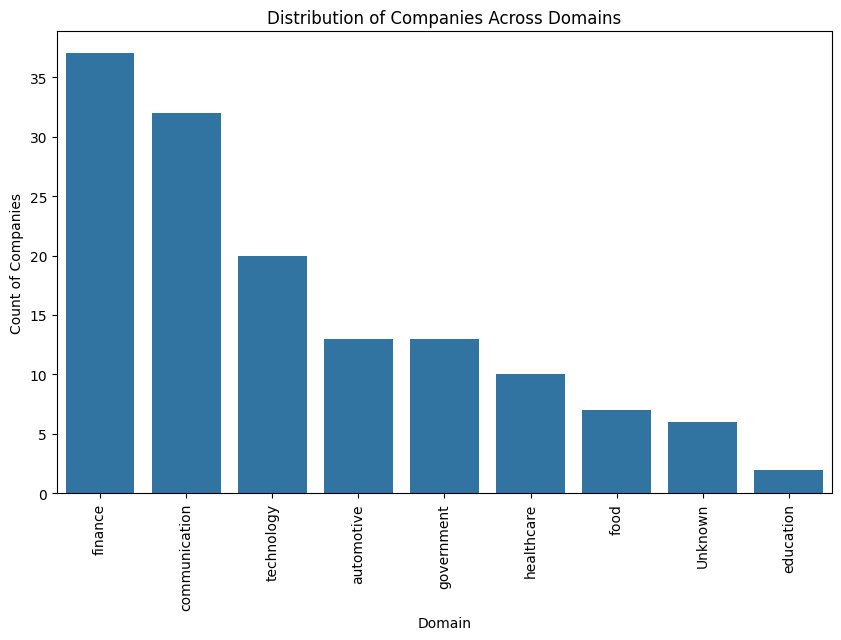

In [ ]:
# Bar plot of domain counts
plt.figure(figsize=(10, 6))
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title('Distribution of Companies Across Domains')
plt.xlabel('Domain')
plt.ylabel('Count of Companies')
plt.xticks(rotation=90)
plt.show()

###Pinecone API key

In [ ]:
# Initialize Pinecone using Pinecone class
# Replace 'your_api_key' with your actual API key
pinecone = Pinecone(api_key='your_api_key')

###Creating index

In [ ]:
pinecone.list_indexes()

{'indexes': [{'deletion_protection': 'disabled',
              'dimension': 384,
              'host': 'companies-index-56zp7p0.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'companies-index',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

In [ ]:
pinecone.delete_index("companies-index")

In [ ]:
index_exists = "companies-index" in pinecone.list_indexes()

# Only create the index if it doesn't exist
if not index_exists:
    pinecone.create_index(
        name="companies-index",
        dimension=384,  # Or the appropriate dimension for your vectors #7568
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        ),
        deletion_protection="disabled"
    )
    print(f"Index 'companies-index' created successfully.")
else:
    print(f"Index 'companies-index' already exists.")

Index 'companies-index' created successfully.


###Model for encoding

In [ ]:
# Load a model for encoding
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

###Encoding in pinecone

In [ ]:
# Function to encode company names
def encode_company_name(company_name):
    inputs = tokenizer(company_name, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1).numpy()
    return embeddings

In [ ]:
# Function to encode company names
def encode_domain_vector(domain):
    inputs = tokenizer(domain, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1).numpy()
    return embeddings

In [ ]:
# Store company names as vectors in Pinecone
index = pinecone.Index('companies-index')

for company in list_unique_cleaned_entities:
    vector = encode_company_name(company)[0]
    index.upsert([(company, vector.tolist())])

for domain in possible_domains:
    vector = encode_domain_vector(domain)[0]  # Replace with your encoding function
    index.upsert([(domain, vector.tolist())])

In [ ]:
index

###Importing Langchain

In [ ]:
from langchain import LLMChain
from langchain_openai import OpenAIEmbeddings as PineconeEmbeddings
from langchain_pinecone import PineconeVectorStore


###OpenAI key

In [ ]:
openai_api_key1 = 'your_open_ai_key'

###Storing vectors

In [ ]:
# Initialize Pinecone embeddings for LangChain
vector_store = PineconeVectorStore(index=index, embedding=PineconeEmbeddings(openai_api_key=openai_api_key1))

###Search company articles

In [ ]:
def search_company_articles(company_name):
    # Encode the query company name
    vector = encode_company_name(company_name)[0].tolist()

    # Query the Pinecone index
    query_result = index.query(vector=vector, top_k=5, include_values=True)

    # Fetch articles from the original DataFrame
    articles = df[df['org_entities'].apply(lambda entities: company_name in entities)]
    return articles[['link', 'date', 'content']], query_result

In [ ]:
articles, query_result = search_company_articles('Apple')
print(articles)

                                                   link        date  \
6     https://www.bloomberg.com/news/articles/2024-0...  2024-08-13   
96    https://www.bloomberg.com/news/articles/2024-0...  2024-08-13   
161   https://www.bloomberg.com/news/articles/2024-0...  2024-08-12   
289   https://www.bloomberg.com/news/articles/2024-0...  2024-08-11   
313   https://www.bloomberg.com/news/articles/2024-0...  2024-08-10   
373   https://www.bloomberg.com/news/articles/2024-0...  2024-08-09   
518   https://www.bloomberg.com/news/articles/2024-0...  2024-08-08   
537   https://www.bloomberg.com/news/articles/2024-0...  2024-08-08   
611   https://www.bloomberg.com/news/articles/2024-0...  2024-08-08   
841   https://www.bloomberg.com/news/articles/2024-0...  2024-08-06   
968   https://www.bloomberg.com/news/articles/2024-0...  2024-08-05   
969   https://www.bloomberg.com/news/articles/2024-0...  2024-08-05   
1002  https://www.bloomberg.com/news/newsletters/202...  2024-08-05   
1010  

###Statistics

In [ ]:
def search_company_articles(company_name):
    # Encode the query company name
    vector = encode_company_name(company_name)[0].tolist()

    # Query the Pinecone index for top 5 relevant articles
    query_result = index.query(vector=vector, top_k=5, include_values=True)

    # Fetch articles mentioning the company from the original DataFrame
    articles = df[df['org_entities'].apply(lambda entities: company_name in entities)][['link', 'date', 'content']]

    # Count the frequency of the company in the dataset
    company_frequency = df['org_entities'].apply(lambda entities: company_name in entities).sum()

    # Add a summary for the frequency statistic
    statistics = {
        "company_name": company_name,
        "total_mentions": company_frequency,
        "top_5_related_articles": articles.head(5)
    }

    return articles, statistics


In [ ]:
articles, statistics = search_company_articles('Apple')
print(statistics)

{'company_name': 'Apple', 'total_mentions': 47, 'top_5_related_articles':                                                   link        date  \
6    https://www.bloomberg.com/news/articles/2024-0...  2024-08-13   
96   https://www.bloomberg.com/news/articles/2024-0...  2024-08-13   
161  https://www.bloomberg.com/news/articles/2024-0...  2024-08-12   
289  https://www.bloomberg.com/news/articles/2024-0...  2024-08-11   
313  https://www.bloomberg.com/news/articles/2024-0...  2024-08-10   

                                               content  
6    Alphabet Inc.’s Google is rolling out upgraded...  
96   Alphabet Inc. investors are anxiously awaiting...  
161  With its hardware event on Tuesday, Alphabet I...  
289  In the race against climate change, government...  
313  As another quarterly earnings season from Corp...  }
